<a href="https://colab.research.google.com/github/doudi25/Triton/blob/main/Inverting_Colors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import triton
import triton.language as tl


In [20]:
@triton.jit
def invert_kernel(image_ptr,stride_b,stride_c,stride_h,stride_w,h,w,BLOCK_SIZE_H:tl.constexpr,BLOCK_SIZE_W:tl.constexpr):
  batch_id = tl.program_id(axis=0)
  channel_id = tl.program_id(axis=1)
  hw_id = tl.program_id(axis=2)
  n_h_pid = tl.cdiv(h,BLOCK_SIZE_H)
  n_w_pid = tl.cdiv(w,BLOCK_SIZE_W)
  height_id = hw_id // n_h_pid
  width_id = hw_id % n_w_pid
  h_offs = height_id * BLOCK_SIZE_H + tl.arange(0,BLOCK_SIZE_H)
  w_offs = width_id * BLOCK_SIZE_W + tl.arange(0,BLOCK_SIZE_W)
  mask = (h_offs[:,None] < h) & (w_offs[None,:] < w)
  h_offs = h_offs[:,None] * stride_h
  w_offs = w_offs[None,:] * stride_w
  input_ptrs = image_ptr + batch_id * stride_b + channel_id * stride_c + h_offs + w_offs
  input = tl.load(input_ptrs,mask=mask)
  input = 255.0 - input
  tl.store(input_ptrs,input)


In [21]:
def invert_colors(images:torch.tensor):
  assert images.ndim == 4
  assert images.is_cuda
  bs,c,h,w = images.shape
  grid = lambda meta:(bs,c,triton.cdiv(h,meta['BLOCK_SIZE_H'])*triton.cdiv(w,meta['BLOCK_SIZE_W']),)
  invert_kernel[grid](image,image.stride(0),image.stride(1),image.stride(2),image.stride(3),h,w,BLOCK_SIZE_H=16,BLOCK_SIZE_W=16)
  return image

In [22]:
import torchvision
image = torchvision.io.read_image('raana.png') # replace it with your image path
image = image.to('cuda').unsqueeze(0)

In [23]:
image = invert_colors(image)

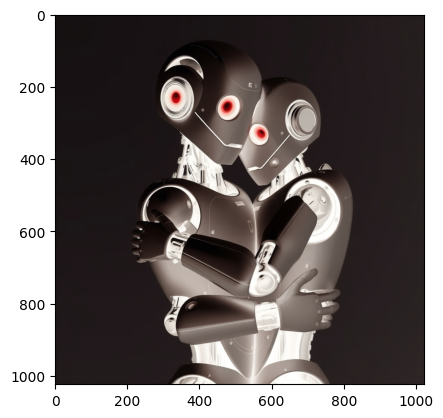

In [24]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze().permute(1,2,0).detach().cpu())